In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

from common import loss_utils

import sys
sys.path.append('./dgmr-oneshot')
import dgmr

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16
FOLDER = 'weights/dgmr_oneshot'
FOLDER = pathlib.Path(FOLDER)
assert FOLDER.exists()

In [5]:
p = pathlib.Path('data/data_good_sun_not_in_train_test.npz')
f = np.load(p)
times = f['times']
data = f['data']


In [6]:
times.shape, data.shape

((25316,), (25316, 325, 400))

In [7]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [8]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [9]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

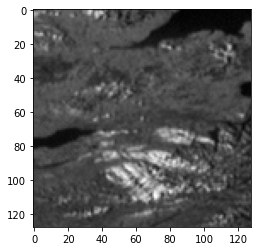

In [11]:
plt.imshow(x[-1], cmap='gray')

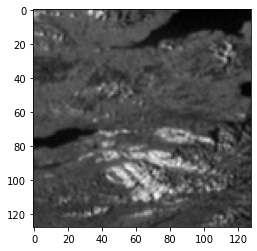

In [12]:
plt.imshow(y[0], cmap='gray')

In [13]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=160,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=96,
    context_channels=160,
    output_channels=1,
)

model = dgmr.generators.Generator(ccs, sampler)
model.load_state_dict(torch.load(FOLDER / 'dgmr_epochs=100_loss=0.183.pt'))
model = model.to(DEVICE)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 235695682 trainable parameters


In [18]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [19]:
model.train()

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)

    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
    score = get_mssim(preds[:,:,:,32:96,32:96], y[:,:,:,32:96,32:96], average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')


Avg Score: 0.8081188174162951: 100%|██████████| 1581/1581 [05:23<00:00,  4.89it/s]


In [20]:
scores = np.array(scores)

In [21]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.9665619 , 0.94837367, 0.93053593, 0.91298129, 0.89630302,
       0.88046017, 0.86536607, 0.85119256, 0.8376885 , 0.82498164,
       0.81301276, 0.80169836, 0.79088534, 0.78051601, 0.77064311,
       0.76109597, 0.75166227, 0.74239511, 0.73337611, 0.72431484,
       0.71541511, 0.70676115, 0.69823367, 0.69039706])

In [22]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

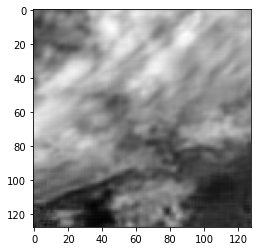

In [25]:
plt.imshow(out[0], cmap='gray')

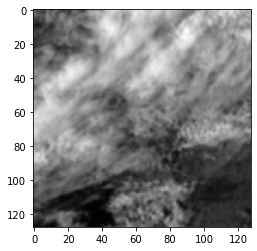

In [27]:
plt.imshow(true[0], cmap='gray')

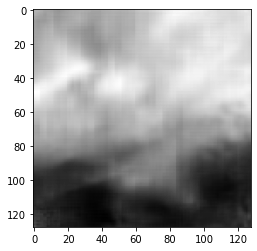

In [29]:
plt.imshow(out[-1], cmap='gray')

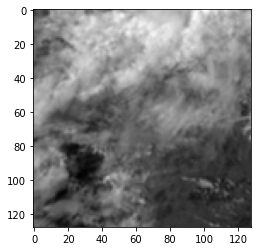

In [31]:
plt.imshow(true[-1], cmap='gray')